In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']

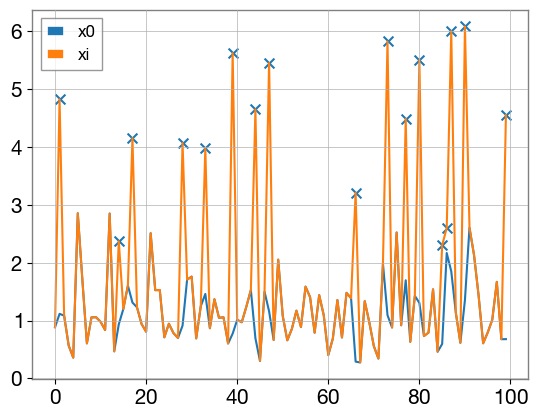

In [2]:
Nsims = 100_000
Nbins = 100
SIGMA = 1 # Likelihood covariance \Sigma = sigma * \mathbb{1}
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.2, bkg=True, dtype=torch.float32, mode='complex')     
samples = simulator.sample(Nsims=Nsims)  

plt.plot(samples['x0'][0], label='x0')
plt.plot(samples['xi'][0], label='xi')
idx = torch.where(samples['ni'][0] != 0)
plt.scatter(idx, samples['xi'][0][idx], marker='x', s=50)
plt.legend();

In [3]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 

    def forward(self, x):
        data = x['xi']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

In [ ]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    # sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
network_epsilon = Network_epsilon()
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();